# Exploratory Data Analysis Using Youtube Video Data from Most Popular City Design Youtube Channels

## 1. Aims, objective and background

### 1.1. Introduction

City design is an important aspect to take into consideration when it comes to deciding about a future job opportunity or move. It represents not only the means of getting around a city (through the amount of investments poured into public transportation or bike paths) but also measures the level of access to services and jobs. __Fifteen-minute cities__ is a planning concept how easy are most necessities reached by a 15-minute walk or bike ride [[1](https://linkinghub.elsevier.com/retrieve/pii/S2214140518305103)].


### 1.2. Aims and objectives

Within this project, I would like to explore the following:

- Getting to know Youtube API and how to obtain video data.
- Analyzing video data and verify different common "myths" about what makes a video do well on Youtube, for example:
    - Does the number of likes and comments matter for a video to get more views?
    - Does the video duration matter for views and interaction (likes/ comments)?
    - Does title length matter for views?
    - How many tags do good performing videos have? What are the common tags among these videos?
    - Across all the creators I take into consideration, how often do they upload new videos? On which days in the week?
- Explore the trending topics using NLP techniques
    - Which popular topics are being covered in the videos (e.g. using wordcloud for video titles)?
    - Which questions are being asked in the comment sections in the videos


In [2]:
import os
from dotenv import load_dotenv
from os import path
from PIL import Image
from googleapiclient.discovery import build
from IPython.display import JSON
from dateutil import parser
import pandas as pd
import numpy as np
import helper_functions as hf

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/yanbadea/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yanbadea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
load_dotenv()

api_key = os.getenv('API_KEY')

In [3]:
# The channels which are to be analysed need to be added here

channel_ids = [
    'UC0intLFzLaudFG-xAvUEO-A', # https://www.youtube.com/c/NotJustBikes
    'UCGc8ZVCsrR3dAuhvUbkbToQ', # https://www.youtube.com/c/CityBeautiful
    'UCfgtNfWCtsLKutY-BHzIb9Q', # https://www.youtube.com/c/CityNerd
    'UC-LM91jkqJdWFvm9B5G-w7Q', # https://www.youtube.com/c/AlanFisher1337
    'UCK1XzxcKXB_v_dcw_tflC1A' # https://www.youtube.com/c/OBFYT
    ]

In [4]:

# Get credentials and create an API client
api_service_name = "youtube"
api_version = "v3"
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [5]:
# Get all the stats from the channels, using helper functions
channel_stats = hf.get_channel_stats(youtube, channel_ids)
video_ids = hf.get_video_ids(youtube, channel_stats['playlistId'][0])
video_df = hf.get_video_details(youtube, video_ids)
comments = hf.get_comments_in_videos(youtube, video_ids)

## Data pre-processing

In [6]:
# Verify whether any row contains null characters
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags              False
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [7]:
# Check the types of video_df
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [8]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,sZILAAPdTzE,City Beautiful,Can we fit ENTIRE cities in a single building?...,Subscribe to Nebula and get $20 off at: https:...,"[city planning, town planning, urban planning,...",2023-08-16T19:00:25Z,78373,4325,None,448,PT12M26S,hd,false
1,bKGiw89OMHQ,City Beautiful,The Most Expensive ZIP codes in the U.S.,"If you want to learn more about 90210, check o...","[city planning, town planning, urban planning,...",2023-08-03T05:51:57Z,129515,4814,None,165,PT57S,hd,false
2,b8_NBbqYkMw,City Beautiful,Why is Beverly Hills So Rich and Famous?,Visit https://brilliant.org/citybeautiful/ to ...,"[city planning, town planning, urban planning,...",2023-07-28T17:17:01Z,269968,6313,None,501,PT12M37S,hd,false
3,yNHlbk4IX6A,City Beautiful,I DESTROYED a European City with U.S. Planning...,Subscribe to Nebula and get $20 off at: https:...,"[city planning, town planning, urban planning,...",2023-07-15T16:00:50Z,121837,5721,None,415,PT58M32S,hd,false
4,sJYB8uxnb1w,City Beautiful,How Did Paris Become a Global Powerhouse? (Ful...,Visit https://brilliant.org/citybeautiful/ to ...,"[city planning, town planning, urban planning,...",2023-06-29T17:00:36Z,130702,4813,None,321,PT13M3S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,L5TFhucZ-R4,City Beautiful,Chicago sold the Chicago Skyway for $1.8 billion,This episode is the unlikely story of a public...,"[chicago, highway, skyway, planning, education...",2017-03-28T18:46:43Z,532402,8256,None,858,PT8M17S,hd,false
145,hbhuGkSQvK0,City Beautiful,Fresno is removing its pedestrian mall. Will i...,"On September 1, 1964, the city leaders of Fres...","[pedestrian mall, city planning, fresno, urban...",2017-02-17T18:28:58Z,138005,2633,None,452,PT7M37S,hd,false
146,7q_0NM0cseQ,City Beautiful,How do the layers of government affect city pl...,You probably know that city governments do cit...,"[city planning, government, planning, urban pl...",2017-02-02T06:11:59Z,37392,1149,None,28,PT4M58S,hd,false
147,9kVWDWMcLT4,City Beautiful,An Introduction to Zoning,"Zoning may seem boring, but it dictates what c...","[education, planning, city planning, zoning, u...",2017-01-17T04:54:53Z,241371,6305,None,370,PT5M58S,hd,false


In [9]:
# Convert several columns from object to numeric
numeric = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric] = video_df[numeric].apply(pd.to_numeric, errors = 'coerce', axis=1)

In [10]:
# Convert the publish dates to time values
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime('%A'))

In [11]:
# Convert the duration of the videos into seconds
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [12]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

## EDA

### Best performing videos

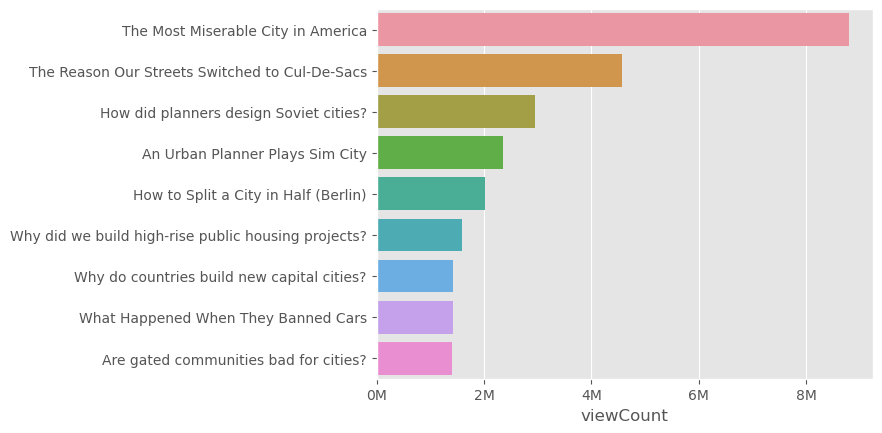

In [13]:
plt.style.use('ggplot')
ax = sns.barplot(x = 'viewCount', y = 'title', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plt.ylabel(None)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000000) + 'M'))

### Worst performing videos

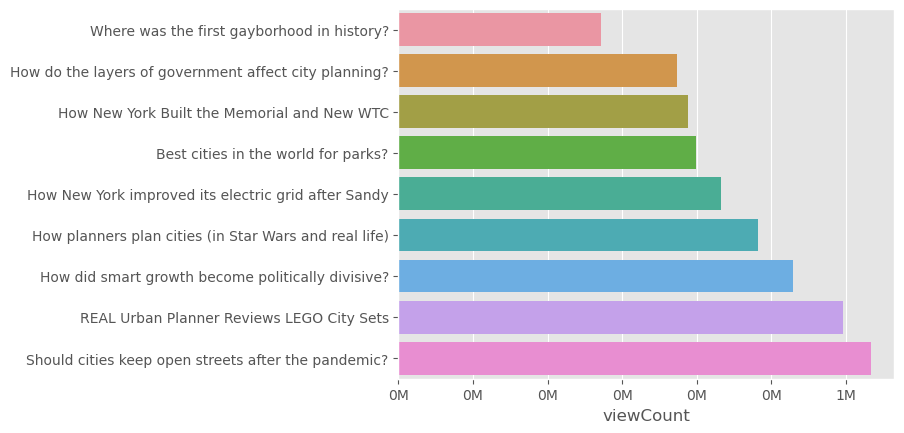

In [14]:
ax = sns.barplot(x = 'viewCount', y = 'title', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plt.ylabel(None)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/100000) + 'M'))

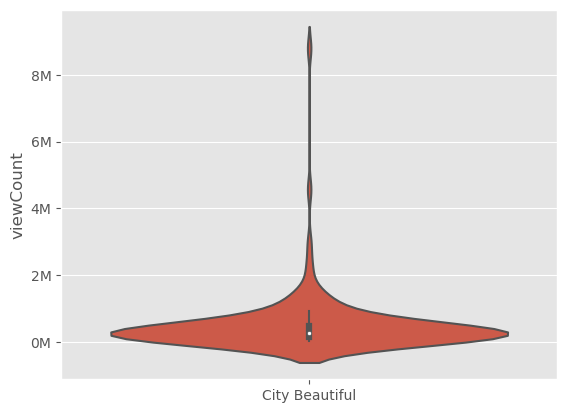

In [15]:
ax = sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])
plt.xlabel(None)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000000) + 'M'))

### Views vs likes and comments

<Axes: xlabel='likeCount', ylabel='viewCount'>

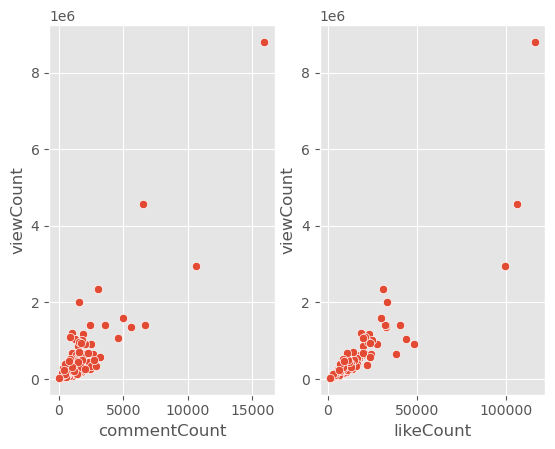

In [16]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y='viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y='viewCount', ax = ax[1])

### Video duration

<Axes: xlabel='durationSecs', ylabel='Count'>

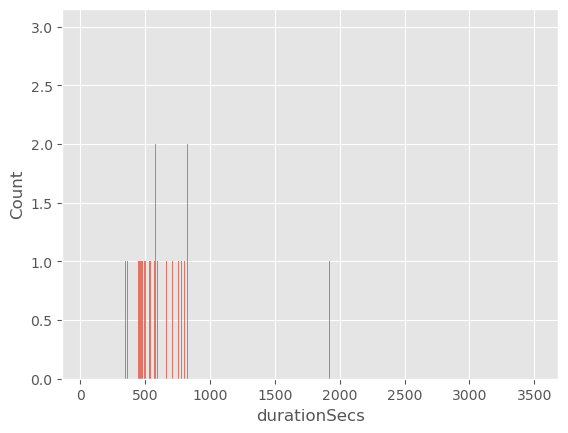

In [17]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

<Figure size 640x480 with 0 Axes>

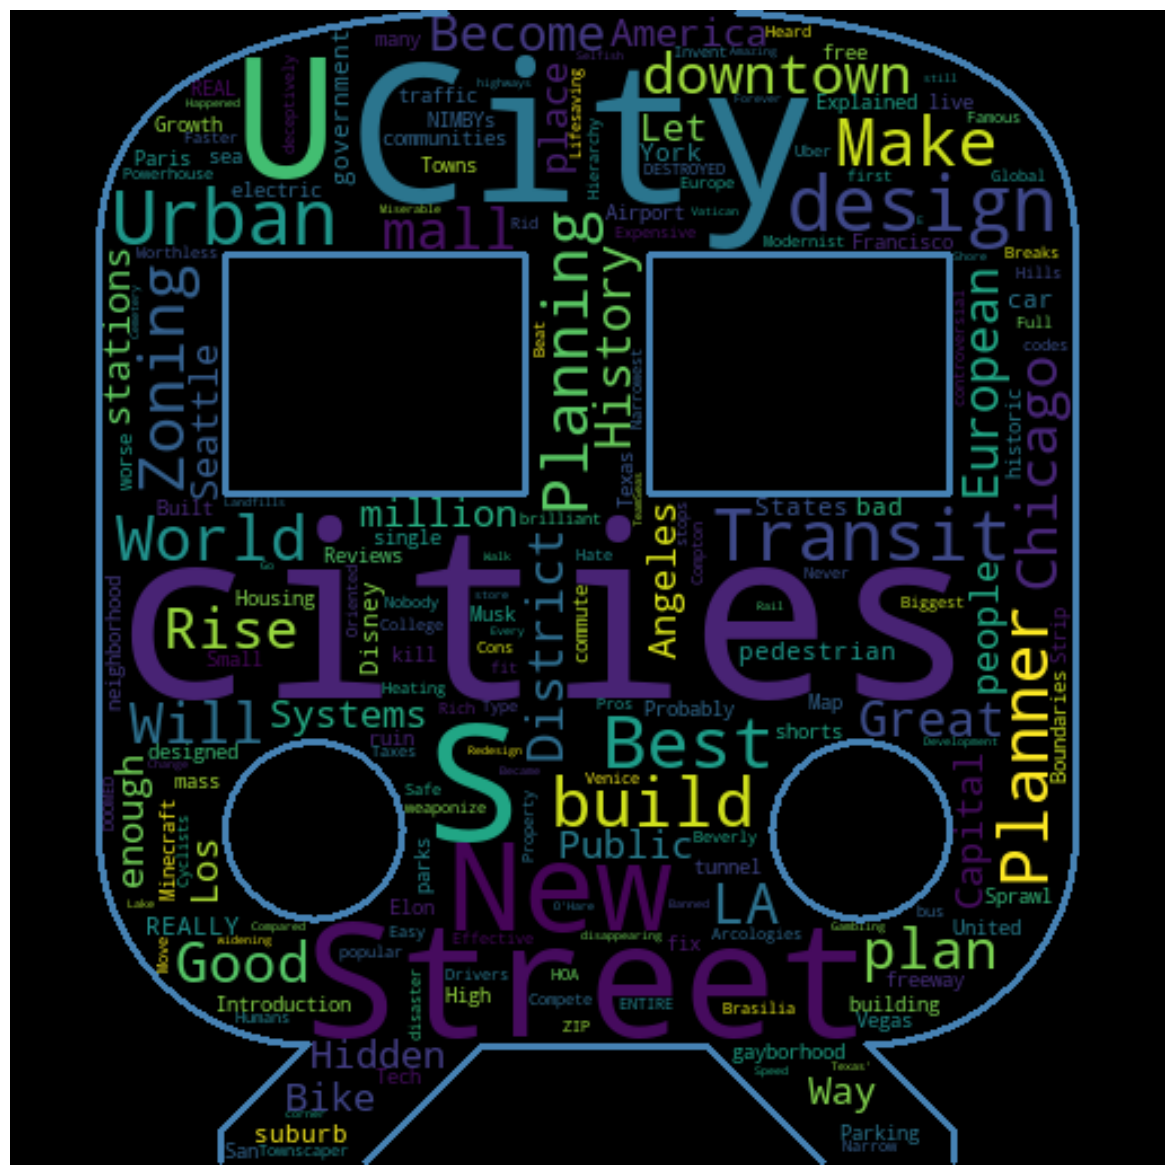

<Figure size 640x480 with 0 Axes>

In [18]:
# A word cloud of the relevant words from the titles from the video of one channel

d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
train_mask = np.array(Image.open(path.join(d, 'train_mask.png')))


stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])


all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)
    
wordcloud = WordCloud(width= 2000, height = 1000, random_state=1, background_color='black',
                      colormap='viridis', collocations=False, mask=train_mask, contour_width=3, contour_color='steelblue').generate(all_words_str)

plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.figure()


In [19]:
# The schedule of the videos from one channel
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)
plt.xlabel(None)

KeyError: 'index'